<a href="https://colab.research.google.com/github/patrick-hanley/thought_experiments/blob/master/_notebooks/2021-02-05-fastai_crunchbase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Can we predict which startup will be aquired?
    I have a set of data from over 49,000 startups indicating their various rounds of funding and their area of focus.

  We know the companies that have been aquired, which ones have failded, and which ones are still independently running.  

 I've created a model that predicts which independent company is going to be aquired.


This [dataset](https://www.kaggle.com/arindam235/startup-investments-crunchbase) originated from Crunchbase and was downloaded from kaggle.



In [1]:
#hide

%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install fastai --upgrade --q

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.style as style
style.use('fivethirtyeight')

from IPython.display import Image, display_svg, SVG
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"



     |████████████████████████████████| 194kB 9.0MB/s 
     |████████████████████████████████| 61kB 3.9MB/s 
Mounted at /content/gdrive


In [2]:
#hide

base_dir = root_dir + 'crunchbase'
path = Path(base_dir)
csv_path = Path(base_dir+'/crunchbase_data_cleaned_3.csv')

# df = pd.read_csv(csv_path)
# cleanup_nums = {"status":     {2: True, 1:False}}
# df = df.replace(cleanup_nums)

# X=df.copy()
# y=X.status

# X.drop('status',inplace=True, axis=1)
# #categorical_features_indices = np.where(X.dtypes == 'object')[0]

# dep_var = 'status'
# cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
# procs = [Categorify, FillMissing]

# # split data into train and test sets
# seed = 7
# test_size = 0.2
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# splits = (list(X_train.index),list(X_test.index))

# to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
# xs, y = to.train.xs,to.train.y
# valid_xs, valid_y = to.valid.xs,to.valid.y


In [18]:
# #hide
# save_pickle(path/'to3.pkl',to)

# to = load_pickle(path/'to3.pkl')

# I used a neural network to encode all the categorical features and extracted the ebedding layers for further analysis.



> ## Instead of a simple label encoding of each feature, we create a vector representation.
  The sample below shows a vector of length 3.  
The advantage is that we are able to transform discreet variable into vectors that are continous and meaningful.
> > ### <img alt="Label Embeddings vs Vector Embedding" width="800" caption="Label Embeddings vs Vector Embedding (derived from latent space of neural network)" id="city_emb" src="https://drive.google.com/uc?id=1zszZ7eTR0Fe0QVhDto_YTrPop_XoyvDB">

---








In the Fast.AI book, [Deep Learning for Coders](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527), an excellent example of the benefits of categorical embedding is provided.

> On the left is a plot of the embedding matrix for the possible values of the State category. For a categorical variable we call the possible values of the variable its "levels" (or "categories" or "classes"), so here one level is "Berlin," another is "Hamburg," etc. On the right is a map of Germany. The actual physical locations of the German states were not part of the provided data, yet the model itself learned where they must be, based only on the behavior of store sales!


### <img alt="State embeddings and map" width="800" caption="State embeddings and map (courtesy of Cheng Guo and Felix Berkhahn)" id="state_emb" src="https://drive.google.com/uc?id=1Vzc203MEmeGa3X3m7MM199xRSMpfbXyV">







# The overall strategy to predict the success (the purchase of the startup) was the following:


1.   Import and clean the data
2.   Creaate additional features
3.   Run data through a neural network to convert categorical data to continous
4.   Train ML models on the latent space of the neural network
5.   Select the most confident prediction





In [308]:
#hide
def feat_importance(m, df):
  # get list of feature importance for given model
  #try:
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                      ).sort_values('imp', ascending=False)
  # except:
  #   return ""
    
def save_predictions(model_name, m, df, target_names, note):
  col = []
  for target_name in target_names:
    tmp = "_".join([model_name, target_name, note])
    col.append(tmp)
  try:
    predictions = m.predict_log_proba(df)
  except:
    predictions = m.predict_proba(df)
  
  predict_df = pd.DataFrame(predictions, columns=col).astype("float")
  delta_name = "_".join(['delta', col[1], col[0]])
  predict_df[delta_name] = predict_df[col[1]] - predict_df[col[0]]
  predict_df['company_index']=df.index
  return predict_df

# modified based on this blog: https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0
def run_exps(models, X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame, note) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param models: array of tuples containing (model_name, model)
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :note: 
    :return: DataFrame of predictions
    '''
    #print ( embeded_xs_1.shape, y_train.shape, xs_valid_1.shape, y_test.shape)
    dfs = []
    dfs_predictions = []

    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['closed', 'aquired']
    for model_name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True,
                                      random_state=90210)
        
        cv_results = model_selection.cross_validate(model, X_train, y_train,
                                                    cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(model_name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        #try:
        fi=feat_importance(clf, X_test)
        plot_fi(model_name, note, fi[:10])
        # except:
        #   print('fail to plot')
        print ()
        predict_df=save_predictions(model_name, clf, X_test, target_names, note)
        names.append(model_name)

        dfs_predictions.append(predict_df)
    prediction_dfs = pd.concat(dfs_predictions, axis=1)
    return prediction_dfs 

def nn_embeddings(emb_szs=None):
  # use a neural network to create ebeddings of categorical data

  learn = tabular_learner(dls,layers=[200,100], metrics=accuracy,
                          emb_szs=emb_szs)


  lr_in, lr_steep = learn.lr_find(show_plot=False)

  learn.fit_one_cycle(20, lr_steep, cbs=EarlyStoppingCallback( 
      monitor='accuracy', min_delta=0.1, patience=2))
  
  # after fitting, get embeddings to be used by ML
  embeded_xs = embed_features(learn, learn.dls.train.xs)
  xs_valid = embed_features(learn, learn.dls.valid.xs)

  return (learn, embeded_xs, xs_valid)

def embed_features(learner, xs):
  # https://forums.fast.ai/t/using-embedding-from-the-neural-network-in-random-forests/80063/9
  # citation: danielwbn
    xs = xs.copy()
    for i, feature in enumerate(learner.dls.cat_names):
        emb = learner.model.embeds[i]
        new_feat = pd.DataFrame(emb(tensor(xs[feature], dtype=torch.int64)), index=xs.index, columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        xs.drop(columns=feature, inplace=True)
        xs = xs.join(new_feat)
    return xs

def plot_fi(name, note, fi):

    title = "_".join([name, note])
    fi_plot = fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
    
    fi_plot.tick_params(axis = 'both', which = 'major', labelsize = 18)
    #fi_plot.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

    # Remove the label of the x-axis
    fi_plot.xaxis.label.set_visible(False)
     # Remove the label of the y-axis
    fi_plot.yaxis.label.set_visible(False)
    titles="        " + title
    fi_plot.text(x = .0, y = 10, s = titles,
               fontsize = 26, weight = 'bold', alpha = .75)
    
    fig=fi_plot.get_figure()
    img_path = Path(base_dir + '/' + title + '.png')
    fig.savefig(img_path, bbox_inches = 'tight')

    return fi_plot



In [309]:
#@title
#hide
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
# George Fisher
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Ensembling the embeddings 
What makes this code unique is the fact that I took the same data and ran it through 4 different neural networks with each one set to a different embedding size.

For each neural network, I extracted the latent layers and trained a Random Forest models on each embedding space and then ensembled the predictions and probabilites. The end result was an improvement of > 6%.  

The predictions improve because each model puts an emphasis on the different features.  The two charts shown below show the top 10 features based on the importance to the model.  Each model provides a different weight to each feature.  Remember, the underlying data is identical, but I'm analyzing the latent space with different embedding sizes.


<!-- ### <img alt="State embeddings and map" width="1200" caption="feature importance of different embedding sizes" id="fi_emb" src="https://drive.google.com/uc?id=1bf2h4DOXLvLChoPCcPSFDh8M87a7nyDF"> -->

<p float="left">
  <img src="https://drive.google.com/uc?id=1-Amuz7zrJL-yO9t7Ip8Tamt8URG5Sntu"/>
  <img src="https://drive.google.com/uc?id=1-hUkVHPhoX-jWVLwhffIR2cYhB22cvms"/> 
</p>









In [380]:
#hide

base_dir = root_dir + 'crunchbase'
path = Path(base_dir)
csv_path = Path(base_dir+'/crunchbase_data_cleaned_3.csv')
df = pd.read_csv(csv_path)

cleanup_nums = {"status":     {2: True, 1:False}}
df = df.replace(cleanup_nums)
company_names = df.name # For use later, but not necessary to use it for learning
city_names=df.city
y=df.status
X=df.copy()
X.drop(['status','name'],axis=1,inplace=True)


# use reduced columns indicated by feature importance
use_reduced = False
dep_var = 'status'

def use_reduced_features(use_reduced):
  if use_reduced:  
    return (df[list(xs_imp.columns) + [dep_var]])

  return df[list(X.columns) + [dep_var]]


df_nn_final = use_reduced_features (use_reduced)

y=df_nn_final.status
X=df_nn_final.copy()
X.drop(['status'],axis=1,inplace=True)


seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
splits = (list(X_train.index),list(X_test.index))


# df_nn_final = df_nn_final.astype({'funding_total_usd': 'int64',
#                                   'first_funding_year':'int64',
#                                   'founded_year':'int64',
#                                   'last_funding_year':'int64',
#                                   'funding_rounds':'int64',
#                                   'venture': 'int64'})

cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=10, dep_var=dep_var)

In [339]:
# _, embeded_xs_1, xs_valid_1 = nn_embeddings(emb_szs)
# model = RandomForestClassifier(max_depth=200, random_state=0, oob_score=True, min_samples_split=30)
# clf = model.fit(embeded_xs_1, y_train)
# y_pred = clf.predict(xs_valid_1)
# target_names = ['closed', 'aquired']
# print(classification_report(y_test, y_pred, target_names=target_names))

In [340]:
# x=save_predictions('df', clf, xs_valid_1, target_names, 'test')
# x.set_index('company_index',inplace=True)
# df_out = pd.merge(company_names, x, how = 'right',left_index = True, right_index = True)
# df_out[:4]

In [341]:
# def save_predictions(model_name, m, df, target_names, note):
#   col = []
#   for target_name in target_names:
#     tmp = "_".join([model_name, target_name, note])
#     col.append(tmp)
#   try:
#     predictions = m.predict_log_proba(df)
#   except:
#     predictions = m.predict_proba(df)
  
#   print (predictions[:4])
#   predict_df = pd.DataFrame(predictions, columns=col).astype("float")
#   delta_name = "_".join(['delta', col[1], col[0]])
#   predict_df[delta_name] = predict_df[col[1]] - predict_df[col[0]]
#   predict_df['company_index']=df.index
#   return predict_df

epoch,train_loss,valid_loss,accuracy,time
0,0.665045,0.653437,0.635057,00:00
1,0.638297,0.625351,0.672414,00:00
2,0.611899,0.622627,0.679598,00:00


No improvement since epoch 0: early stopping
RandomForest
              precision    recall  f1-score   support

      closed       0.68      0.61      0.64       308
     aquired       0.71      0.77      0.74       388

    accuracy                           0.70       696
   macro avg       0.70      0.69      0.69       696
weighted avg       0.70      0.70      0.70       696




epoch,train_loss,valid_loss,accuracy,time
0,0.695834,0.668175,0.617816,00:00
1,0.656790,0.635582,0.660920,00:00
2,0.621600,0.637344,0.649425,00:00


No improvement since epoch 0: early stopping
RandomForest
              precision    recall  f1-score   support

      closed       0.68      0.60      0.64       308
     aquired       0.71      0.78      0.74       388

    accuracy                           0.70       696
   macro avg       0.70      0.69      0.69       696
weighted avg       0.70      0.70      0.70       696




epoch,train_loss,valid_loss,accuracy,time
0,0.667974,0.663915,0.632184,00:00
1,0.639916,0.641762,0.658046,00:00
2,0.605195,0.619631,0.663793,00:00


No improvement since epoch 0: early stopping
RandomForest
              precision    recall  f1-score   support

      closed       0.67      0.60      0.63       308
     aquired       0.71      0.76      0.73       388

    accuracy                           0.69       696
   macro avg       0.69      0.68      0.68       696
weighted avg       0.69      0.69      0.69       696




epoch,train_loss,valid_loss,accuracy,time
0,0.692642,0.690661,0.577586,00:00
1,0.643617,0.665631,0.626437,00:00
2,0.593527,0.636637,0.627874,00:00


No improvement since epoch 0: early stopping
RandomForest
              precision    recall  f1-score   support

      closed       0.65      0.59      0.62       308
     aquired       0.70      0.75      0.72       388

    accuracy                           0.68       696
   macro avg       0.68      0.67      0.67       696
weighted avg       0.68      0.68      0.68       696




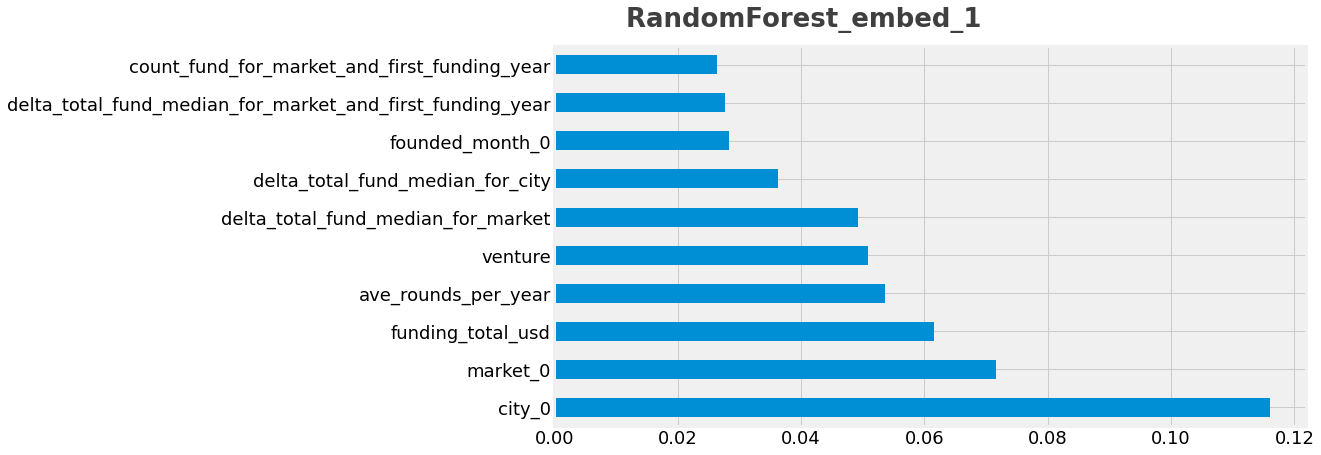

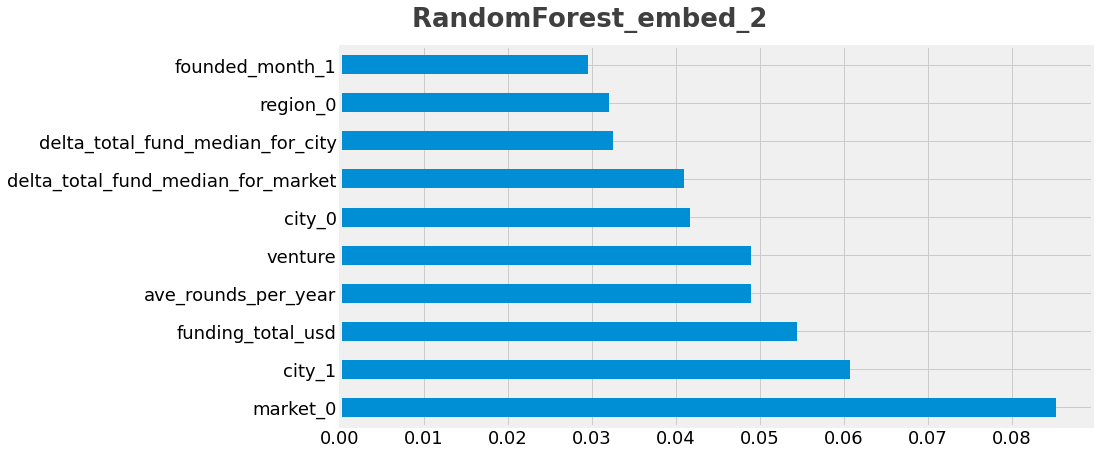

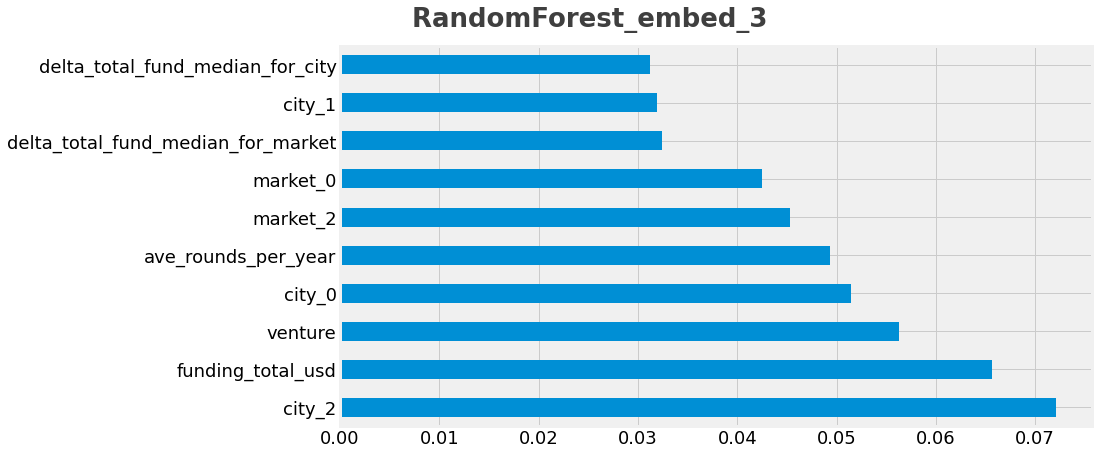

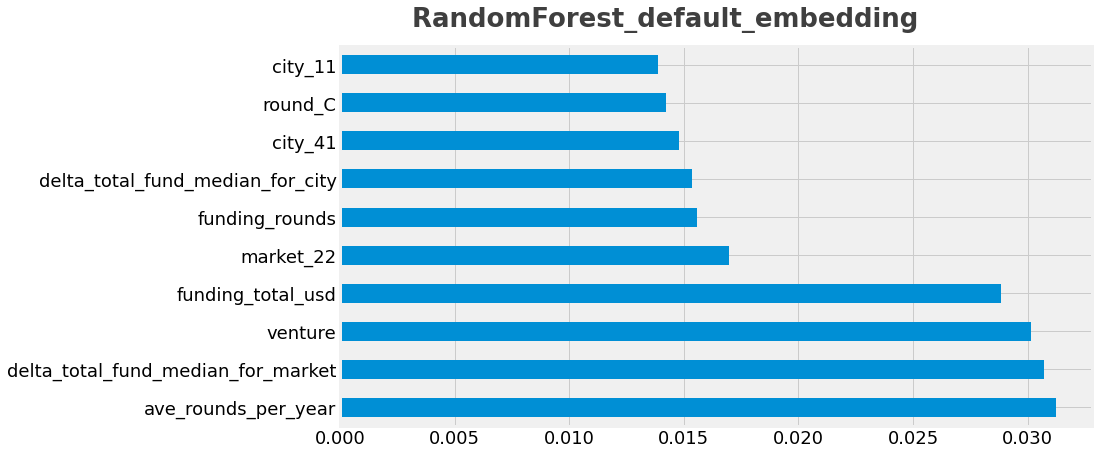

In [400]:
models = [
      ('RandomForest', RandomForestClassifier(max_depth=200, random_state=0,
                                     oob_score=True, min_samples_split=30)),
    ]

procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

dls = to_nn.dataloaders(512)

emb_szs={'city':1, 'market':1,'region':1,'founded_month':1, 
         'founded_quarter':1,'state_code':1}
_, embeded_xs_1, xs_valid_1 = nn_embeddings(emb_szs)

embed_1_df = run_exps(models, embeded_xs_1, y_train, xs_valid_1, y_test,
                      'embed_1')


emb_szs={'city':2, 'market':2,'region':2,'founded_month':2, 
         'founded_quarter':2,'state_code':2}
_, embeded_xs_2, xs_valid_2 = nn_embeddings(emb_szs)
embed_2_df = run_exps(models, embeded_xs_2, y_train, xs_valid_2, y_test,
                      'embed_2')


emb_szs={'city':3, 'market':3,'region':3,'founded_month':3, 
         'founded_quarter':3,'state_code':3}
_, embeded_xs_3, xs_valid_3 = nn_embeddings(emb_szs)
embed_3_df = run_exps(models, embeded_xs_3, y_train, xs_valid_3, y_test,
                         'embed_3')


_, embeded_xs_default, xs_valid_default = nn_embeddings()
embed_default_df = run_exps(models, embeded_xs_default, y_train,
                            xs_valid_default, y_test, 'default_embedding')

In [402]:
embed_default_df[:2]

,RandomForest_closed_default_embedding,RandomForest_aquired_default_embedding,delta_RandomForest_aquired_default_embedding_RandomForest_closed_default_embedding,company_index
0,-0.775900,-0.616722,0.159177,1334
1,-1.242999,-0.340405,0.902595,2956


# The ensemble of the latent layers improves the model by > 6%.  To reach 95% accuracy, I focus on the top 20% of the companies based on the confidence of the model.




In [393]:
combined_predictions[:3]

,RandomForest_closed_embed_1,RandomForest_aquired_embed_1,delta_RandomForest_aquired_embed_1_RandomForest_closed_embed_1,RandomForest_closed_embed_2,RandomForest_aquired_embed_2,delta_RandomForest_aquired_embed_2_RandomForest_closed_embed_2,RandomForest_closed_embed_3,RandomForest_aquired_embed_3,delta_RandomForest_aquired_embed_3_RandomForest_closed_embed_3,RandomForest_closed_default_embedding,RandomForest_aquired_default_embedding,delta_RandomForest_aquired_default_embedding_RandomForest_closed_default_embedding,combined_confidence
0,-0.638725,-0.750702,-0.111977,-0.843760,-0.562277,0.281483,-0.617333,-0.775184,-0.157850,-0.830649,-0.572287,0.258363,0.270019
1,-0.968282,-0.477608,0.490674,-1.495104,-0.253893,1.241212,-1.104923,-0.402325,0.702598,-1.206554,-0.355571,0.850983,3.285467
2,-1.100683,-0.404432,0.696251,-1.418883,-0.277051,1.141832,-1.385770,-0.287857,1.097913,-1.588922,-0.228339,1.360583,4.296579


RF2
              precision    recall  f1-score   support

      closed       0.67      0.67      0.67        54
     aquired       0.79      0.79      0.79        86

    accuracy                           0.74       140
   macro avg       0.73      0.73      0.73       140
weighted avg       0.74      0.74      0.74       140




,RF2_closed_combined_model_predictions,RF2_aquired_combined_model_predictions,delta_RF2_aquired_combined_model_predictions_RF2_closed_combined_model_predictions,company_index
0,-0.059858,-2.845556,-2.785698,2760.0
1,-0.487981,-0.951567,-0.463586,1151.0
2,-0.032075,-3.455683,-3.423608,3359.0
3,-0.367923,-1.178208,-0.810285,1537.0
4,-1.161375,-0.375502,0.785873,2940.0
...,...,...,...,...
135,-0.176936,-1.819133,-1.642198,1936.0
136,-1.333523,-0.305910,1.027613,427.0
137,-0.532525,-0.884600,-0.352075,1032.0
138,-2.203457,-0.117007,2.086451,244.0


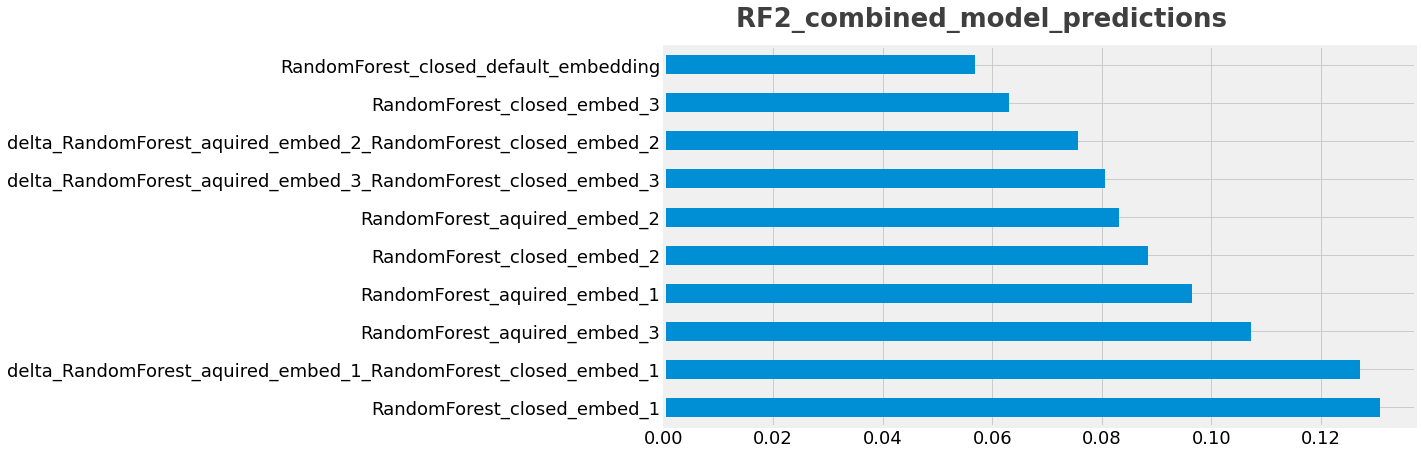

In [430]:
#collapse-show
#combine all predictions into single DF
del combined_predictions
combined_predictions = pd.concat([embed_1_df, embed_2_df, embed_3_df, embed_default_df ], axis=1)
combined_predictions = combined_predictions.T.drop_duplicates().T
combined_predictions.set_index('company_index', inplace=True)
combined_predictions.drop(['company_index'],axis=1,inplace=True, errors='ignore')
combined_predictions.drop(['combined_confidence'],axis=1,inplace=True, errors='ignore')

# add new feature summing predictions
# combined_predictions['combined_confidence'] = combined_predictions.delta_RandomForest_aquired_embed_1_RandomForest_closed_embed_1 +\
#  combined_predictions.delta_RandomForest_aquired_embed_2_RandomForest_closed_embed_2 +\
#                   combined_predictions.delta_RandomForest_aquired_embed_3_RandomForest_closed_embed_3 +\
#                    combined_predictions.delta_RandomForest_aquired_default_embedding_RandomForest_closed_default_embedding

#now need to split d2 into train and valid sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(combined_predictions, y_test, test_size=test_size, random_state=seed)

models = [  
      ('RF2', RandomForestClassifier(max_depth=200, random_state=0,
                                     oob_score=True, min_samples_split=30)),
    ]

run_exps(models, X_train_combined, y_train_combined, X_test_combined,
         y_test_combined, 'combined_model_predictions')

In [431]:
 
#clf = RandomForestClassifier(max_depth=3, random_state=0, oob_score=False, min_samples_split=100, n_estimators=5)
clf = RandomForestClassifier(max_depth=200, random_state=0, oob_score=True, min_samples_split=30)
clf.fit(X_train_combined, y_train_combined)
print (clf.score(X_test_combined, y_test_combined))

0.7428571428571429


In [433]:
y_test_combined[:4]

2760    False
1151    False
3359    False
1537     True
Name: status, dtype: bool

In [428]:
pred_df[:4]

,z,o,target,pred,diff
0,-0.059858,-2.845556,False,False,-2.785698
1,-0.487981,-0.951567,False,False,-0.463586
2,-0.032075,-3.455683,False,False,-3.423608
3,-0.367923,-1.178208,True,False,-0.810285


In [429]:
y_test_combined[:4]

2760    False
1151    False
3359    False
1537     True
Name: status, dtype: bool

In [449]:
#hide
predicted_val=clf.predict_proba(X_test_combined)


pred_df=pd.DataFrame(predicted_val, columns=['z','o'])
#pred_df['names']=(X_test_combined.company_index.values)

pred_df['target']=y_test_combined.values
pred_df['names']=y_test_combined.index
pred_df['pred']=predicted


pred_df['diff'] = pred_df.apply(lambda x: x['o'] - x['z'], axis=1)

#pred_df=pred_df[np.abs(pred_df['diff'])>1.4]
#pred_df=pred_df[(pred_df['diff']>1.7) | (pred_df['diff']<-1.58)] #93 with 4 models
confident_pred_df=pred_df[(pred_df['diff']>1.21) | (pred_df['diff']<-1.22)] #92 with 1 model
confident_pred_df=pred_df[(pred_df['diff']>.75) | (pred_df['diff']<-.75)] #92 with 1 model
#confident_pred_df=pred_df


#confident_pred_df.sort_values(by='diff')

confident_pred_df.set_index('names',inplace=True)

df_out = pd.merge(company_names, confident_pred_df, how = 'right',left_index = True, right_index = True)
df_out.sort_values(by='diff')

#confident_pred_df

,name,z,o,target,pred,diff
names,,,,,,
3359,WHObyYOU,0.968434,0.031566,False,False,-0.936869
1851,MobAppCreator,0.966083,0.033917,False,False,-0.932165
847,Dormzy,0.952883,0.047117,False,False,-0.905766
2760,Social GameWorks,0.941898,0.058102,False,False,-0.883796
1514,JumpTheClub,0.912027,0.087973,False,False,-0.824054
2445,Rebel Monkey,0.883964,0.116036,False,False,-0.767927
178,AnySource Media,0.121905,0.878095,True,True,0.756189
2380,Pure Networks,0.120661,0.879339,True,True,0.758678
2964,Tacoda,0.112574,0.887426,True,True,0.774852


# Interesting high confidence predictions
I predicted Kickfire was aquired with a 79% confidence, however the data listed it as a company that is closed.  After investigation, Kickfire was actually aquired in 2010 by [Teradata](https://www.teradata.com/).  Details can be found in this [article](https://https://www.infoworld.com/article/2625533/teradata-buys-analytics-vendor-kickfire.html).


The other company that I predicted would get aquired is Breaktime Studios.  This company went under in 2016.

While I was able to make accurate predictions on the limited data of market type and the aount of funding in each round.  It would have been helpful to know who was making the investments.  Was it credible VCs with a known trackrecord or individuals.  Stay tuined while I add this to the model.




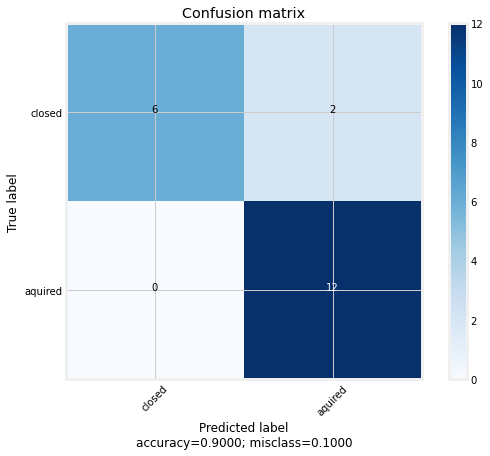

In [450]:
#collapse-show
cm=confusion_matrix(df_out.target, df_out.pred,  labels=None, sample_weight=None, normalize=None)
plot_confusion_matrix(cm, ['closed','aquired'], normalize=None)

#decision tree


epoch,train_loss,valid_loss,accuracy,time
0,0.686024,0.674187,0.633621,00:01
1,0.656219,0.651108,0.646552,00:01
2,0.635543,0.636986,0.666667,00:01
3,0.619859,0.644567,0.668103,00:01
4,0.606075,0.637931,0.655172,00:01
5,0.597032,0.637052,0.647988,00:01


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


NameError: ignored

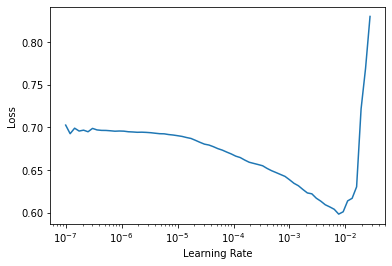

In [ ]:
#hide

# Lets loop over embedding sizes (0,1,2,4,8,16,32,64)
embedding_sizes = [0,1,2,4,8,16,32,64,128]
embedding_sizes = [5,6,7,8,9,10]
embedding_sizes =[2,3,4,5,6,7,8,16,32,64,128,1]
 
embedding_sizes =[3]

for inc, es in enumerate(embedding_sizes):
  city_es = 3
  market_es = 3
  region_es = 6
  founded_month_es = 1
  founded_quarter_es = 32
  state_code_es = 7 #es

  city_es = es
  market_es = es
  region_es = es
  founded_month_es =es
  founded_quarter_es = es
  state_code_es = es #es

#clf = RandomForestClassifier(max_depth=200, random_state=0, oob_score=True, min_samples_split=30)
  clf = RandomForestClassifier(max_depth=20, random_state=0, oob_score=True, min_samples_split=25)
  learn = tabular_learner(dls,layers=[2000,1000],metrics=accuracy ,
                          emb_szs={'city':city_es, #+2,
                                   'market':market_es,
                                   'region':region_es,
                                   'founded_month':founded_month_es, 
                                   'founded_quarter':founded_quarter_es,
                                   'state_code':state_code_es})
  learn.lr_find()
  learn.fit_one_cycle(6, .0001, cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=6))
  embeded_xs = embed_features(learn, learn.dls.train.xs)
  xs_valid = embed_features(learn, learn.dls.valid.xs)

  clf.fit(embeded_xs, learn.dls.targ)
  trn=clf.score(embeded_xs, learn.dls.targ)
  val=clf.score(xs_valid, y_test)

  ebedded_df.at[inc, 'ebedding_size'] = es
  ebedded_df.at[inc, 'trn_score'] = trn
  ebedded_df.at[inc, 'val_score'] = val


  fi = rf_feat_importance(clf, xs_valid)
  print(es, trn, val)
  for feature in cat_nn:
    col_fi=fi[fi['cols'].str.contains(feature)] # market contains 13.2% of the important features with embedding of 8
    col_sum = col_fi.imp.sum()
    print (es, feature, col_sum )
    ebedded_df.at[inc, feature] = col_sum

ebedded_df

In [451]:
pca = decomposition.PCA(n_components=2)
pca.fit(d)
X = pca.transform(X_test_combined)

fig = px.scatter(x=X[:, 0], y=X[:, 1], color=y.values, marginal_y="violin")#, text=df_out2.city,
          # marginal_x="box", trendline="ols")

fig.show()

NameError: ignored

In [ ]:
from sklearn import decomposition

In [ ]:
pca = decomposition.PCA(n_components=2)
pca.fit(embeded_xs)
X = pca.transform(embeded_xs)
y = learn.dls.targ

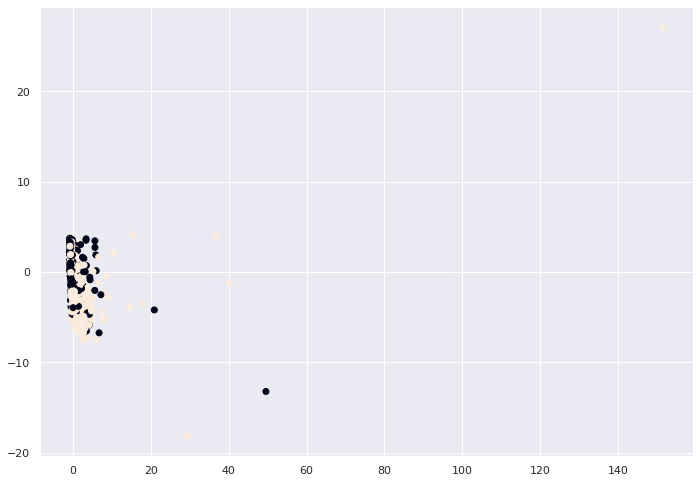

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y.values) # this is pca without embeddings

In [454]:
import plotly.express as px

In [ ]:
fig = px.scatter(x=X[:, 0], y=X[:, 1], color=y.values, marginal_y="violin", text=df_out.name,
           marginal_x="box", trendline="ols")

In [ ]:
fig = px.scatter(x=X[:, 0], y=X[:, 1], color=y.values, marginal_y="violin", text=df_out2.city,
           marginal_x="box", trendline="ols")

In [ ]:
fig.show()

In [452]:
from sklearn.manifold import TSNE
tsne = TSNE()
X = tsne.fit_transform(X_test_combined)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=3.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000)
X = tsne.fit_transform(d)

In [3]:
y_test_combined2 = pd.DataFrame(y_test_combined.values, columns=['tar'])
y_test_combined2[:4]


NameError: ignored

In [469]:

y_test_combined['somecolumn'] = y_test_combined.replace({True: 1, False: 0})
fig = px.scatter(x=X[:, 0], y=X[:, 1], color=y_test_combined.s, marginal_y="violin")#, text=df_out2.city,
         #  marginal_x="box", trendline="ols")

#fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], color=y.values,  text=df_out2.city)
fig.show()

TypeError: ignored

In [ ]:
fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], color=y.values)
fig.show()

In [4]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

sns.scatterplot(data=X_embedded, x=X_embedded[:,0], y=X_embedded[:,1], hue=learn.dls.targ.status)

NameError: ignored

#combine nn, rf+nn_ebeddings, xgb+nn_ebeddings


In [ ]:
base_dir = root_dir + 'crunchbase/master'
path = Path(base_dir)
csv_path = Path(base_dir+'/investments.csv')

investments_df=pd.read_csv(csv_path)

In [ ]:
investments_df.columns

Index(['company_permalink', 'company_name', 'company_category_list',
       'company_country_code', 'company_state_code', 'company_region',
       'company_city', 'investor_permalink', 'investor_name',
       'investor_country_code', 'investor_state_code', 'investor_region',
       'investor_city', 'funding_round_permalink', 'funding_round_type',
       'funding_round_code', 'funded_at', 'raised_amount_usd'],
      dtype='object')

In [ ]:
investments_df.company_name.describe()

count     168646
unique     44578
top         Uber
freq          64
Name: company_name, dtype: object

In [ ]:
#limit to USA
investments_df.investor_permalink.fillna('xxx', inplace=True)
investments_df = investments_df[investments_df.company_country_code=='USA']
unique_investors=investments_df.copy()
unique_investors = investments_df[['company_name','investor_permalink','investor_name','funded_at']].copy()

In [ ]:
unique_investors[:5]

,company_name,investor_permalink,investor_name,funded_at
1,004 Technologies,/organization/venturecapital-de,VCDE Venture Partners,2014-07-24
3,H2O.ai,/organization/capital-one,Capital One,2015-11-09
4,H2O.ai,/organization/nexus-venture-partners,Nexus Venture Partners,2013-05-22
5,H2O.ai,/organization/nexus-venture-partners,Nexus Venture Partners,2015-11-09
6,H2O.ai,/organization/nexus-venture-partners,Nexus Venture Partners,2013-01-03


In [ ]:
unique_investors.investor_permalink=unique_investors.investor_permalink.astype('string')
#unique_investors.investor_permalink=unique_investors.investor_permalink.to_string()

In [ ]:
n=unique_investors.investor_permalink.str.split('/',n =2, expand = True)
n

,0,1,2
1,,organization,venturecapital-de
3,,organization,capital-one
4,,organization,nexus-venture-partners
5,,organization,nexus-venture-partners
6,,organization,nexus-venture-partners
...,...,...,...
168630,,organization,prolog-ventures
168631,,organization,state-of-wisconsin-investment-board
168632,,organization,stonehenge-capital
168633,,organization,venture-investors


In [ ]:
#unique_investors['investor_type']=new_df.iloc[:,1]

#unique_investors.investor_permalink.fillna('xxx', inplace=True)
#unique_investors.investor_permalink=unique_investors.investor_permalink.to_string()

unique_investors.loc[unique_investors['investor_permalink'].str.contains("organization"),'investor_type'] = 'organization'
unique_investors.loc[unique_investors['investor_permalink'].str.contains("person"),'investor_type'] = 'person'


In [ ]:
unique_investors=unique_investors.drop_duplicates()
unique_investors.shape

(112065, 3)

In [ ]:
unique_investors[['investor_name','p']].nunique()

investor_name    19687
p                    3
dtype: int64

# how many VC companies

In [ ]:
org_invest=unique_investors[unique_investors.p=='organization']
org_invest.groupby(by=['company_name','funded_at'])['investor_name'].count().agg(["mean", "median", "max", "min"])

mean       2.407946
median     2.000000
max       22.000000
min        1.000000
Name: investor_name, dtype: float64

In [ ]:
org_invest.investor_name.describe()

count                         93333
unique                        11408
top       New Enterprise Associates
freq                            810
Name: investor_name, dtype: object

In [ ]:
unique_investors.groupby(by=['company_name'])['investor_name'].count()

company_name
#BratPackStyle, LLC.    1
#waywire                6
.                       1
//Staq.io               1
004 Technologies        1
                       ..
zkipster                1
zlien                   3
zulily                  6
zuuka!                  5
Ôasys                   1
Name: investor_name, Length: 23040, dtype: int64

In [ ]:
t=unique_investors.groupby(by=['company_name','funded_at'])['investor_name']
t

In [ ]:
unique_investors['total_unique_img_rows_per_patient']=unique_investors.groupby(['company_name','funded_at'])["investor_name"].transform('nunique')

In [ ]:
def get_investor_type(df):
 
  #if df['investor_permalink'].contains('organization'):
  if 'organization' in df['investor_permalink']:
    df['p']='organization'
  elif 'person' in df['investor_permalink']:
  # elif df.investor_permalink.str.contains('person'):
    df['p']='person'
  else:
    df['p']='xxx'
  return df


unique_investors=unique_investors.apply(get_investor_type, axis=1)


In [ ]:
unique_investors['investor_permalink'][:20]

1             /organization/venturecapital-de
3                   /organization/capital-one
4        /organization/nexus-venture-partners
5        /organization/nexus-venture-partners
6        /organization/nexus-venture-partners
7        /organization/nexus-venture-partners
8       /organization/paxion-capital-partners
9                  /organization/transamerica
10        /organization/transamerica-ventures
11               /person/anand-babu-periasamy
12                  /person/anand-rajaraman-2
13                       /person/ash-bhardwaj
14                      /person/michael-marks
15                      /person/rajesh-ambati
16                      /person/rakesh-mathur
17            /organization/camp-one-ventures
18            /organization/camp-one-ventures
19       /organization/charles-river-ventures
20    /organization/general-catalyst-partners
21                /organization/kima-ventures
Name: investor_permalink, dtype: object

In [ ]:
unique_investors.p.value_counts()

organization    93333
person          18943
xxx                 7
Name: p, dtype: int64